# Two Step Dispatch

**NOT STABLE. DOES NOT SOLVE FOR ALL TIMESTEPS. BELOW IS OUTDATED CODE, DO NOT RUN**

PyPSA-GB can model the GB power system in two steps by (i) optimising the dispatch of generators by solving a Unit Commitment (UC) problem and fixing the commitment schedule, and (ii) re-dispatching the committed generator units by solving a network constrained Linear Optimal Power Flow (LOPF) problem. The UC problem simulates the wholesale market and the LOPF problem simulates the balancing mechanism.

In [ ]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [1]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
import data_reader_writer

import cartopy.crs as ccrs

In [2]:
# dates need to include the last hour to be modelled + horizon
# i.e. to model one day, need to include next day too
start = '2019-06-02 00:00:00'
end = '2019-06-04 23:30:00'
# year of simulation
year = 2019
# time step as fraction of hour
time_step = 0.5
# want unit commitment marginal prices? True or False
UC_marginal_prices = False

data_reader_writer.data_writer(start, end, time_step, year)

C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB\data_reader_writer.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hydro2['type'] = np.select(conditions, type_)
C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB\data_reader_writer.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [3]:
network = pypsa.Network()
network.import_from_csv_folder(csv_folder_name='UC_data')

Importing PyPSA from older version of PyPSA than current version 0.18.0.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network UC_data has buses, generators, loads, storage_units


In [4]:
network2 = pypsa.Network()
network2.import_from_csv_folder(csv_folder_name='LOPF_data')

Importing PyPSA from older version of PyPSA than current version 0.18.0.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network LOPF_data has buses, generators, lines, links, loads, storage_units


In [5]:
# set the horizon length and number of batches
horizon = 48
batches = 48

for i in range(int(batches)):

    print('Batch number: ', i)

    # set the initial state of charge based on previous round
    if i > 0:
        # both UC and LOPF use the updated state of charge from LOPF
        network.storage_units.state_of_charge_initial = (
            network2.storage_units_t.state_of_charge.loc[network.snapshots[i - 1]])
        network2.storage_units.state_of_charge_initial = (
            network2.storage_units_t.state_of_charge.loc[network.snapshots[i - 1]])

        # set the up time and down time before inputs for committable UC gens
        # as this represents the actually run outputs

        # want to do the below for all generators
        gen_index = network.generators.index
        # remove renewable generation
        gen_index = gen_index.drop(
            ['PV', 'wind_onshore', 'wind_offshore', 'hydro',
             'BritNed', 'EastWest', 'Moyle', 'Nemo',
             'IFA', 'IFA2'])

        for gen in gen_index:

            # print(network2.generators_t.p.iloc[i - 1][gen], ' power in previ timestep')
            if network2.generators_t.p.iloc[i - 1][gen] > 0:
                # this means the generator was on in previous timestep...
                # down time before goes to zero
                network.generators.down_time_before.loc[gen] = 0
                # add one to the up_time_before...
                network.generators.up_time_before.loc[gen] += 1

            elif network2.generators_t.p.iloc[i - 1][gen] == 0:
                # this means the generator was off in previous timestep...
                # add one to the down_time_before
                network.generators.down_time_before.loc[gen] += 1
                # up time goes to zero
                network.generators.up_time_before.loc[gen] = 0

    # two step unit comittment optional
    # only need the second step if interested in marginal prices from this step

    if UC_marginal_prices is False:

        network.lopf(network.snapshots[i:i + horizon], solver_name="gurobi")

    elif UC_marginal_prices is True:

        # Build a pyomo model corresponding to the pypsa network
        model = pypsa.opf.network_lopf_build_model(
            network,
            snapshots=network.snapshots[i:i + horizon])
        # Prepare a pyomo optimizer object, here with gurobi
        opt = pypsa.opf.network_lopf_prepare_solver(
            network, solver_name="gurobi")
        # solve the MILP
        opt.solve(model).write()
        # fixing the generator_status makes the problem linear (LP)
        model.generator_status.fix()
        # solve again with fixed generators
        network.results = opt.solve(model)
        network.results.write()
        # import back to pypsa datastructures
        pypsa.opf.extract_optimisation_results(
            network, network.snapshots[i:i + horizon])

    # to approximate n-1 security and allow room for reactive power flows,
    # don't allow any line to be loaded above 70% of their thermal rating
    contingency_factor = 0.7
    network2.lines.s_max_pu = contingency_factor

    # power of generators in the timestep to be modelled
    s = network.generators_t.p.iloc[i]
    s = s.drop(['BritNed', 'EastWest', 'Moyle', 'Nemo',
            'IFA', 'IFA2'])
    # index of names of generators which are zero power
    gen_non_zero = s[s > 0].index
    # enforce a must run condition
    # on non-zero generators from UC using p_min_pu
    for gen in range(len(gen_non_zero)):
        network2.generators.p_min_pu.loc[gen_non_zero[gen]] = (
            network.generators.p_min_pu.loc[gen_non_zero[gen]])

    # network constrained on single snapshot
    network2.lopf(network2.snapshots[i:i + 1], solver_name="gurobi")

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


Batch number:  0


INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2407048.3130425806
  Upper bound: 2407048.3130425806
  Number of objectives: 1
  Number of constraints: 98053
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 359518
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminatio

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 48461.075714768194
  Upper bound: 48461.075714768194
  Number of objectives: 1
  Number of constraints: 325
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 3299
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mo

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2143866.0196554707
  Upper bound: 2143866.0196554707
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 352046
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminatio

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 48466.4007147682
  Upper bound: 48466.4007147682
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2123693.4344713152
  Upper bound: 2123693.4344713157
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 354420
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminatio

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 48281.725714768196
  Upper bound: 48281.725714768196
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2106568.486776002
  Upper bound: 2106568.486776002
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 356567
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 47747.05071476819
  Upper bound: 47747.05071476819
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2092238.3847020688
  Upper bound: 2092238.3847020688
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 358325
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminatio

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 41032.37571476819
  Upper bound: 41032.37571476819
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2082598.8548217544
  Upper bound: 2082598.8548217544
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 359273
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminatio

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 40917.700714768194
  Upper bound: 40917.700714768194
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2073849.6353465007
  Upper bound: 2073849.6353465007
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 359573
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminatio

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 36903.0257147682
  Upper bound: 36903.0257147682
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2068392.952545144
  Upper bound: 2068392.952545144
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 359873
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 36888.350714768196
  Upper bound: 36888.350714768196
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2091233.858895611
  Upper bound: 2091436.629923836
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360173
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 33965.58996106259
  Upper bound: 33965.58996106259
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2091494.8835300726
  Upper bound: 2091524.1903744135
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360473
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminatio

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 55814.39852266744
  Upper bound: 55814.39852266744
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2087929.256453757
  Upper bound: 2087982.317965276
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360766
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 60346.31207562141
  Upper bound: 60346.31207562141
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2083568.879905694
  Upper bound: 2083625.640753014
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360786
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 58949.81985350607
  Upper bound: 58949.81985350607
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2080136.1195523422
  Upper bound: 2080323.7053912026
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360806
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminatio

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 61461.050320117196
  Upper bound: 61461.050320117196
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2080251.3433705154
  Upper bound: 2080326.4710590574
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360826
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminatio

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 57255.106693865804
  Upper bound: 57255.106693865804
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2086657.0258722685
  Upper bound: 2086823.6302281378
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360846
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminatio

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 49156.77159048147
  Upper bound: 49156.77159048147
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2111074.527626124
  Upper bound: 2111096.193025839
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360866
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 54016.28777673452
  Upper bound: 54016.28777673452
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2149795.021995927
  Upper bound: 2149845.2222634875
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360886
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 53230.483475131376
  Upper bound: 53230.483475131376
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2174236.272149511
  Upper bound: 2174269.337846578
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360906
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 51050.287271192894
  Upper bound: 51050.287271192894
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2204078.6329942634
  Upper bound: 2204236.713005628
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360926
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 52727.43123805897
  Upper bound: 52727.43123805897
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2240586.77004546
  Upper bound: 2240586.77004546
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360946
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination me

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 53576.250956201555
  Upper bound: 53576.250956201555
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2256773.368108445
  Upper bound: 2256773.368108445
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360965
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 64257.62802035185
  Upper bound: 64257.62802035185
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2261927.0096260956
  Upper bound: 2262093.706773094
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360965
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 64255.39600116744
  Upper bound: 64255.39600116744
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2263725.069075117
  Upper bound: 2263826.0729373707
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360965
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 58905.44210467693
  Upper bound: 58905.44210467693
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2294850.689339336
  Upper bound: 2294850.689339336
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360965
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 55113.89978596641
  Upper bound: 55113.89978596641
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2325594.2942239083
  Upper bound: 2325594.2942239083
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360586
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminatio

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 62284.89795697579
  Upper bound: 62284.89795697579
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2394184.2150824703
  Upper bound: 2394184.2150824703
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360606
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminatio

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 54785.170502277324
  Upper bound: 54785.170502277324
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2485934.7476430256
  Upper bound: 2486158.8819623524
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360626
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminatio

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 50786.274999999994
  Upper bound: 50786.274999999994
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2604451.0025987886
  Upper bound: 2604660.134625971
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360646
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 50707.34043216602
  Upper bound: 50707.34043216602
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2728571.5702824146
  Upper bound: 2728754.314826131
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360666
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 60932.6635943699
  Upper bound: 60932.6635943699
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2845924.4637740115
  Upper bound: 2846025.2784164855
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360686
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminatio

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 59066.26883384539
  Upper bound: 59066.26883384539
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 2989200.933743382
  Upper bound: 2989267.7336483053
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360706
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 62292.49829336599
  Upper bound: 62292.49829336599
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 3137389.6663769367
  Upper bound: 3137445.724171335
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360726
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 65544.9691787456
  Upper bound: 65544.9691787456
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 3299426.6446598377
  Upper bound: 3299549.2124580503
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360746
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminatio

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 71274.85751991044
  Upper bound: 71274.85751991044
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 3517821.0259011732
  Upper bound: 3517958.2915901
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360766
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination m

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 82714.83526848495
  Upper bound: 82714.83526848495
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 3752927.972095916
  Upper bound: 3753171.906770252
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360786
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 93181.86903598202
  Upper bound: 93181.86903598202
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 4003291.971892151
  Upper bound: 4003459.362270448
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360801
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 104720.87311362528
  Upper bound: 104720.87311362528
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 4271443.959968229
  Upper bound: 4271480.962604845
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360824
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 108770.35074115936
  Upper bound: 108770.35074115936
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 4511693.072580775
  Upper bound: 4511980.813518373
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360846
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 107239.7634380052
  Upper bound: 107239.7634380052
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 4762525.973664932
  Upper bound: 4762901.870004556
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360866
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 108800.75303779762
  Upper bound: 108800.75303779762
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 4985245.045781334
  Upper bound: 4985616.660771251
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360871
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 100031.98535842882
  Upper bound: 100031.98535842882
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 5207017.672307692
  Upper bound: 5207026.445940176
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360900
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 98763.99024959927
  Upper bound: 98763.99024959927
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 5425879.22685601
  Upper bound: 5425985.7344643315
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360926
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 96403.20262367683
  Upper bound: 96403.20262367683
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 5644279.662212944
  Upper bound: 5644838.989323651
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360946
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 97128.70425038318
  Upper bound: 97128.70425038318
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 5857230.701040183
  Upper bound: 5857713.483284658
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360965
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 98575.607392636
  Upper bound: 98575.607392636
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 6045201.248341559
  Upper bound: 6045489.870013081
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360965
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 96252.03166872055
  Upper bound: 96252.03166872055
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 6214775.074194779
  Upper bound: 6215325.704958692
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360965
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 77896.40898010615
  Upper bound: 77896.40898010615
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 6384060.526135922
  Upper bound: 6384461.108604175
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360965
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 74084.55973975622
  Upper bound: 74084.55973975622
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x46417
  Lower bound: 6540603.61624313
  Upper bound: 6540893.122195231
  Number of objectives: 1
  Number of constraints: 99335
  Number of variables: 46417
  Number of binary variables: 7536
  Number of integer variables: 7536
  Number of continuous variables: 38881
  Number of nonzeros: 360965
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination m

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2781
  Lower bound: 56807.50304936757
  Upper bound: 56807.50304936757
  Number of objectives: 1
  Number of constraints: 5651
  Number of variables: 2781
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2781
  Number of nonzeros: 8625
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

In [6]:
# can now see marginal prices from unit commitment
print(network.buses_t.marginal_price)
print(network.generators_t.status)
print(network.generators_t.p)

name                 bus
snapshot                
2019-06-02 00:00:00  NaN
2019-06-02 00:30:00  NaN
2019-06-02 01:00:00  NaN
2019-06-02 01:30:00  NaN
2019-06-02 02:00:00  NaN
...                  ...
2019-06-04 21:30:00  0.0
2019-06-04 22:00:00  0.0
2019-06-04 22:30:00  0.0
2019-06-04 23:00:00  0.0
2019-06-04 23:30:00  0.0

[144 rows x 1 columns]
name                 Drax - coal units  Cottam  West Burton  Aberthaw B  \
snapshot                                                                  
2019-06-02 00:00:00                0.0     0.0          0.0         0.0   
2019-06-02 00:30:00                0.0     0.0          0.0         0.0   
2019-06-02 01:00:00                0.0     0.0          0.0         0.0   
2019-06-02 01:30:00                0.0     0.0          0.0         0.0   
2019-06-02 02:00:00                0.0     0.0          0.0         0.0   
...                                ...     ...          ...         ...   
2019-06-04 21:30:00                1.0     1.0     

In [7]:
# can now see marginal prices from LOPF
print(network2.buses_t.marginal_price.head(batches))

name                 Beauly  Peterhead   Errochty  Denny/Bonnybridge  \
snapshot                                                               
2019-06-02 00:00:00     5.0   5.000000   5.000000           5.000000   
2019-06-02 00:30:00     0.0   0.000000   0.000000           0.000000   
2019-06-02 01:00:00     0.0   0.000000   0.000000           0.000000   
2019-06-02 01:30:00     0.0   0.000000   0.000000           0.000000   
2019-06-02 02:00:00     0.0   0.000000   0.000000           0.000000   
2019-06-02 02:30:00     0.0   0.000000   0.000000           0.000000   
2019-06-02 03:00:00     0.0   0.000000   0.000000           0.000000   
2019-06-02 03:30:00     0.0   0.000000   0.000000           0.000000   
2019-06-02 04:00:00     0.0  17.333321   6.616590          14.466132   
2019-06-02 04:30:00     0.0  17.333321   6.616590          14.466132   
2019-06-02 05:00:00     0.0  17.333321   6.616590          14.466132   
2019-06-02 05:30:00     0.0  17.333321   6.616590          14.46

In [8]:
p_by_carrier = network2.generators_t.p.groupby(
    network2.generators.carrier, axis=1).sum()

storage_by_carrier = network2.storage_units_t.p.groupby(
    network2.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

# interconnector exports
exports = network2.loads_t.p
# multiply by negative one to convert it as a generator
# i.e. export is a positive load, but negative generator
exports['Interconnectors Export'] = exports.iloc[:, -6:].sum(axis=1) * -1
interconnector_export = exports[['Interconnectors Export']].iloc[0:batches]

# group biomass stuff
p_by_carrier['Biomass'] = (
    p_by_carrier['Biomass (dedicated)'] + p_by_carrier['Biomass (co-firing)'] +
    p_by_carrier['Landfill Gas'] + p_by_carrier['Anaerobic Digestion'] +
    p_by_carrier['Sewage Sludge Digestion'])

# rename the hydro bit
p_by_carrier = p_by_carrier.rename(
    columns={'Large Hydro': 'Hydro',
             'Interconnector': 'Interconnectors Import'}).iloc[0:batches]

print(p_by_carrier)

carrier              Anaerobic Digestion  Biomass (co-firing)  \
snapshot                                                        
2019-06-02 00:00:00                317.6                  0.0   
2019-06-02 00:30:00                315.6                  0.0   
2019-06-02 01:00:00                307.4                  0.0   
2019-06-02 01:30:00                314.1                  0.0   
2019-06-02 02:00:00                315.6                  0.0   
2019-06-02 02:30:00                314.1                  0.0   
2019-06-02 03:00:00                315.6                  0.0   
2019-06-02 03:30:00                315.6                  0.0   
2019-06-02 04:00:00                314.4                  0.0   
2019-06-02 04:30:00                309.4                  0.0   
2019-06-02 05:00:00                307.4                  0.0   
2019-06-02 05:30:00                307.4                  0.0   
2019-06-02 06:00:00                307.4                  0.0   
2019-06-02 06:30:00      

C:\Users\alyden\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1391: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


Text(0.5, 0, '')

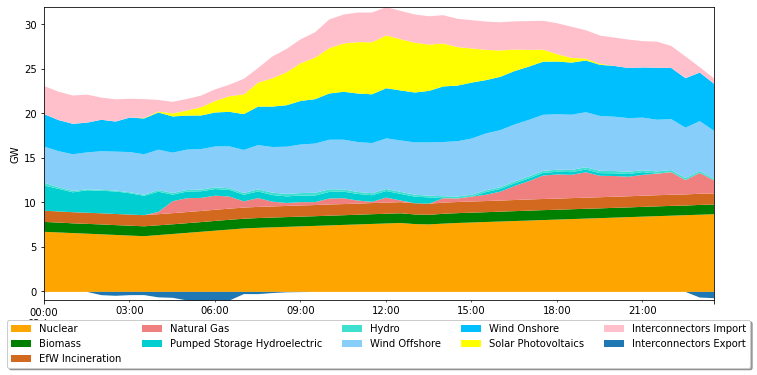

In [9]:
cols = ["Nuclear", 'Shoreline Wave', 'Biomass',
        'EfW Incineration',
        "Coal", "Oil", "Natural Gas",
        "Pumped Storage Hydroelectric", 'Hydro',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
        'Interconnectors Import'
        ]

p_by_carrier = p_by_carrier[cols]

p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 50.0]).index,
    axis=1, inplace=True)

colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Anaerobic Digestion': 'green',
          'EfW Incineration': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'Interconnectors Import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 6)
(p_by_carrier / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])

# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
(interconnector_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)
# rescale the y axis
ax.set_ylim([(interconnector_export / 1e3).sum(axis=1).min(), (p_by_carrier / 1e3).sum(axis=1).max()])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("GW")

ax.set_xlabel("")

Text(0.5, 0, '')

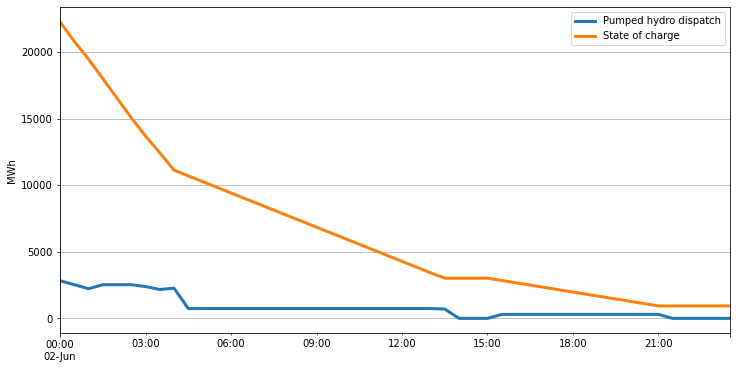

In [10]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 6)

p_storage = network2.storage_units_t.p.sum(axis=1).iloc[0:batches]
state_of_charge = network2.storage_units_t.state_of_charge.sum(axis=1).iloc[0:batches]
p_storage.plot(label="Pumped hydro dispatch", ax=ax, linewidth=3)
state_of_charge.plot(label="State of charge", ax=ax, linewidth=3)

ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")

In [11]:
now = network2.snapshots[0]

loading = network2.lines_t.p0.loc[now] / network2.lines.s_nom
loading.describe()

count    99.000000
mean      0.083896
std       0.189685
min      -0.391061
25%      -0.011973
50%       0.068311
75%       0.159451
max       0.649841
dtype: float64

(<matplotlib.collections.PatchCollection at 0x1d1d25f7f40>,
 <matplotlib.collections.LineCollection at 0x1d1d1bc96a0>)

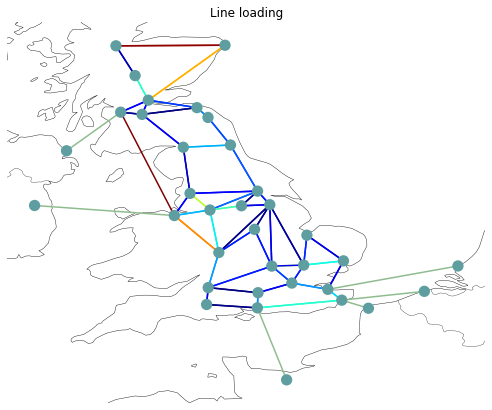

In [12]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(16, 7)

network2.plot(ax=ax, line_colors=abs(loading), line_cmap=plt.cm.jet, title="Line loading")

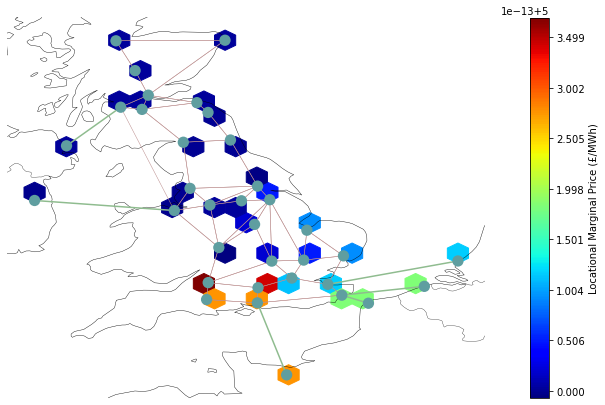

In [13]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(16, 7)

network2.plot(ax=ax, line_widths=pd.Series(0.5, network2.lines.index))
plt.hexbin(network2.buses.x, network2.buses.y,
           gridsize=20,
           C=network2.buses_t.marginal_price.loc[now],
           cmap=plt.cm.jet)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label('Locational Marginal Price (£/MWh)')

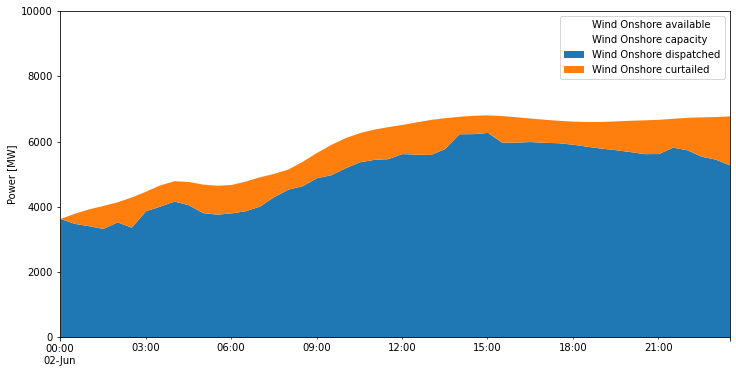

In [14]:
carrier = "Wind Onshore"

capacity = network2.generators.groupby("carrier").sum().at[carrier, "p_nom"]
p_available = network2.generators_t.p_max_pu.multiply(network2.generators["p_nom"])
p_available_by_carrier = p_available.groupby(network2.generators.carrier, axis=1).sum()
p_curtailed_by_carrier = p_available_by_carrier - p_by_carrier
p_df = pd.DataFrame({carrier + " available": p_available_by_carrier[carrier],
                     carrier + " dispatched": p_by_carrier[carrier],
                     carrier + " curtailed": p_curtailed_by_carrier[carrier]}).iloc[0:batches]

p_df[carrier + " capacity"] = capacity
p_df["Wind Onshore curtailed"][p_df["Wind Onshore curtailed"] < 0.] = 0.
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 6)
p_df[[carrier + " dispatched", carrier + " curtailed"]].plot(kind="area", ax=ax, linewidth=0)
p_df[[carrier + " available", carrier + " capacity"]].plot(ax=ax, linewidth=0)

ax.set_xlabel("")
ax.set_ylabel("Power [MW]")
ax.set_ylim([0, 10000])
ax.legend()